# Team YSI - Titanic: Machine Learning from Disaster

## Version 1

In [1]:
#########################################################################
#
# Titanic: Machine Learning from Disaster
#
# Python script for generation of a model predicting the survivals.
#
# Amendment date             Amended by            Description
# 22/11/2016                 Ivaylo Shalev         Initial version.
# 26/11/2016                 Ivaylo Shalev         Added LR for Age missing values.
#
#
#########################################################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier


# Reading of input data (train and test)
main_train_df = pd.read_csv('input/train.csv', header=0)      # Load the train file into a dataframe
main_test_df = pd.read_csv('input/test.csv', header=0)        # Load the test file into a dataframe

# The test data doesn't contain the target (survived), however it still can be used when we are doing data preparation
# That's why we create a third dataframe which will contain both training and test data into one.
# When executing the modeling we will split them back.
main_all_df = main_train_df.append(main_test_df)              # Create a union between both data frames

# Show some stats
print "Training data - number of rows: %s" % main_train_df['PassengerId'].size
print "Testing data - number of rows:  %s" % main_test_df['PassengerId'].size
print "Total data - number of rows:    %s" % main_all_df['PassengerId'].size
print ""

# training data
print "ALL DATA"
# show first row
print main_all_df.iloc[0]
print ""
# show last row
print main_all_df.iloc[-1]
print ""


Training data - number of rows: 891
Testing data - number of rows:  418
Total data - number of rows:    1309

ALL DATA
Age                                 22
Cabin                              NaN
Embarked                             S
Fare                              7.25
Name           Braund, Mr. Owen Harris
Parch                                0
PassengerId                          1
Pclass                               3
Sex                               male
SibSp                                1
Survived                             0
Ticket                       A/5 21171
Name: 0, dtype: object

Age                                 NaN
Cabin                               NaN
Embarked                              C
Fare                            22.3583
Name           Peter, Master. Michael J
Parch                                 1
PassengerId                        1309
Pclass                                3
Sex                                male
SibSp                        

In [2]:
# Data Preparation

# PassengerId - do nothing (as it is - int), but it will not be used as a feature
# Pclass - do nothing (as it is - int 1,2,3)
# SibSp - do nothing (as it is - int 1,2,3,4,5,6,7,8)
# Parch - do nothing (as it is - int 1,2,3,4,5,6,7,8)

# Survived - convert to int
main_all_df['Survived'] = main_all_df.ix[main_all_df.Survived.isnull() == False, 'Survived'].astype(np.int)

# Sex - convert it to ID (int): 0 - female, 1 - male
main_all_df['GenderId'] = [ 0 if x == 'female' else 1 for x in main_all_df['Sex'] ]

# Cabin - extract Deck letter and convert it to ID (int)
main_all_df['DeckId'] = [ 0 if np.isnan(x) else x.astype(int) for x in main_all_df['Cabin'].str[:1].map(
        {
            'T': 1 # Boat Deck - most top
         ,  'A': 2 # higher
         ,  'B': 3
         ,  'C': 4
         ,  'D': 5
         ,  'E': 6
         ,  'F': 7
         ,  'G': 8 # lowest deck
        })]


main_all_df.ix[(main_all_df.DeckId == 0) & (main_all_df.Fare > 30) & (main_all_df.Fare < 38), 'DeckId'] = 1
#main_all_df.ix[(main_all_df.DeckId == 0) & (main_all_df.Fare > 37) & (main_all_df.Fare < 45), 'DeckId'] = 2
main_all_df.ix[(main_all_df.DeckId == 0) & (main_all_df.Fare > 110) & (main_all_df.Fare < 130), 'DeckId'] = 3
main_all_df.ix[(main_all_df.DeckId == 0) & (main_all_df.Fare > 95) & (main_all_df.Fare < 110), 'DeckId'] = 4
main_all_df.ix[(main_all_df.DeckId == 0) & (main_all_df.Fare > 52) & (main_all_df.Fare < 60), 'DeckId'] = 5
#main_all_df.ix[(main_all_df.DeckId == 0) & (main_all_df.Fare > 45) & (main_all_df.Fare < 53), 'DeckId'] = 6
main_all_df.ix[(main_all_df.DeckId == 0) & (main_all_df.Fare > 15) & (main_all_df.Fare < 25), 'DeckId'] = 7
main_all_df.ix[(main_all_df.DeckId == 0) & (main_all_df.Fare > 10) & (main_all_df.Fare < 16), 'DeckId'] = 8
#print main_all_df.groupby('DeckId').count()['PassengerId']

# Family Size - sum SibSp + Parch + 1
main_all_df['FamSize'] = main_all_df.SibSp + main_all_df.Parch + 1
main_all_df['FamSizeId'] = 0
main_all_df.loc[(main_all_df.FamSize > 1) & (main_all_df.FamSize <= 4), 'FamSizeId'] = 1
main_all_df.loc[(main_all_df.FamSize > 4), 'FamSizeId'] = 2

# Name - extract family name and title
# Name - Surname
main_all_df['Surname'] = main_all_df['Name'].replace("(\\,..*)", "", regex=True)
main_all_df['SurnameId'] = main_all_df['Surname'] + "_" + main_all_df['FamSize'].astype(str)

# Name - Title - group common titles and factor them all
main_all_df['Title'] = main_all_df['Name'].replace("(.*, )|(\\..*)", "", regex=True)
common_titles = [['Other', 0], ["Miss", 1], ["Mr", 2], ["Master", 3], ["Mile", 1], ["Ms", 1], ["Mme", 2]]
common_titles_dict = { title : i for title, i in common_titles }
main_all_df['TitleId'] = [ 'Other' if x not in list(common_titles_dict) else x for x in main_all_df['Title'] ]
main_all_df['TitleId'] = main_all_df['TitleId'].map( lambda x: common_titles_dict[x])


# Embarked - decode letter to ID (int)
main_all_df['EmbarkedId'] = [ 0 if np.isnan(x) else x.astype(int) for x in main_all_df['Embarked'].map(
        {
            'C': 1 # Cherbourg
         ,  'Q': 2 # Queenstown
         ,  'S': 3 # Southampton
        })]


# Child
main_all_df['Child'] = 0
main_all_df.loc[main_all_df.Age < 18, 'Child'] = 1

# Mother
main_all_df['Mother'] = 0
main_all_df.loc[  (main_all_df.Age >= 18)
                & (main_all_df.Parch > 0)
                & (main_all_df.GenderId == 0)
                & (main_all_df.Title != "Miss"), 'Mother'] = 1

# FareGroupId
main_all_df['FareGroupId'] = 0
main_all_df.ix[(main_all_df.Fare >  0) & (main_all_df.Fare <= 10), 'FareGroupId'] = 1
main_all_df.ix[(main_all_df.Fare > 10) & (main_all_df.Fare <= 20), 'FareGroupId'] = 2
main_all_df.ix[(main_all_df.Fare > 20) & (main_all_df.Fare <= 30), 'FareGroupId'] = 3
main_all_df.ix[(main_all_df.Fare > 30), 'FareGroupId'] = 4

Training Age model...
Accuracy: 0.49 (+/- 0.07)
Predicting Age...
Done.


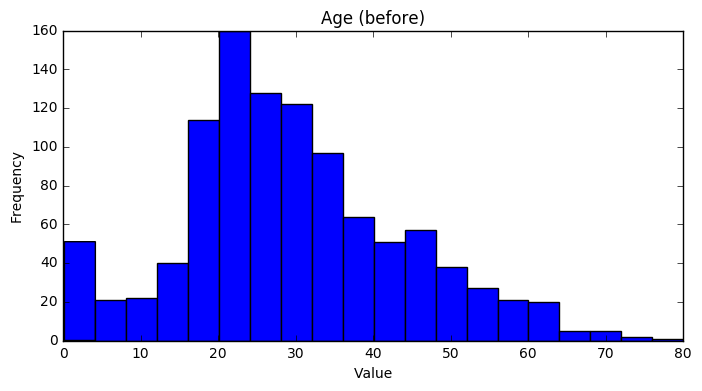

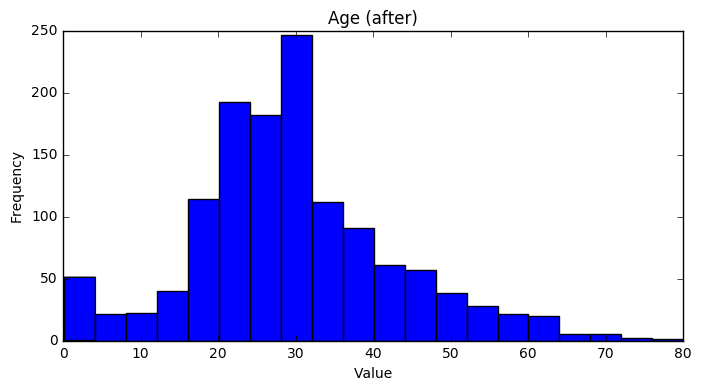

In [3]:
# Age - build regression model to fill the missing age values

plt.figure(figsize=(8,4))
plt.title('Age (before)')
plt.xlabel('Value')
main_all_df['Age'].plot.hist(bins=20)

# create train and target df
all_age_train_df = main_all_df[[
     'Age'
    ,'Survived'
    ,'TitleId'
    ,'GenderId'
    ,'Pclass'
    ,'Child'
    #,'FareGroupId'
    #,'FamSizeId'
    #,'SibSp'
    #,'EmbarkedId'
    #,'Parch'
    #,'Mother'
    #,'DeckId'
    #,'Fare'
]]
age_train_df = all_age_train_df.loc[all_age_train_df['Age'].notnull()].copy()
age_null_df = all_age_train_df.loc[all_age_train_df['Age'].isnull()].copy()
age_target_df = age_train_df['Age'].copy()
age_train_df.drop(['Age'], axis = 1, inplace=True)
age_null_df.drop(['Age'], axis = 1, inplace=True)

# Linear Regression
print 'Training Age model...'
lreg = LinearRegression()

# Cross validation
scores = cross_validation.cross_val_score(lreg
                                          ,age_train_df
                                          ,age_target_df
                                          ,cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Predict
print 'Predicting Age...'
lreg = lreg.fit(age_train_df, age_target_df)
lreg_result = lreg.predict(age_null_df)
#print lreg_result[1:5]
main_all_df.loc[np.isnan(main_all_df["Age"]), 'Age'] = lreg_result
print 'Done.'


plt.figure(figsize=(8,4))
plt.title('Age (after)')
plt.xlabel('Value')
main_all_df['Age'].plot.hist(bins=20)

plt.show()

In [6]:
# Classification

# Split into Train and Test DF
# get only the good features, ID and Target
all_good_df = main_all_df[[
     'PassengerId'
    ,'Survived'
    ,'TitleId'
    ,'GenderId'
    ,'Age'
    ,'Pclass'
    #,'FareGroupId'
    #,'FamSizeId'
    #,'SibSp'
    #,'EmbarkedId'
    #,'Parch'
    #,'Child'
    #,'Mother'
    #,'DeckId'
    #,'Fare'
]]

# Split rows into original sets
train_df = all_good_df.ix[all_good_df.PassengerId <= 891]
test_df = all_good_df.ix[all_good_df.PassengerId > 891]

# Get ID and Target
test_ids = test_df['PassengerId'].values
target_df = all_good_df.ix[all_good_df.PassengerId <= 891, 'Survived']

# Remove ID and Target columns from the datasets
train_df = train_df.drop(['PassengerId', 'Survived'], axis = 1)
test_df = test_df.drop(['PassengerId', 'Survived'], axis = 1)

# RandomForest
print 'Training...'
forest_model = RandomForestClassifier(n_estimators=100)

# Cross validation
scores = cross_validation.cross_val_score(forest_model
                                          ,train_df
                                          ,target_df
                                          ,cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


# Predict
print 'Predicting...'
forest_model = forest_model.fit(train_df, target_df)
predict_output = forest_model.predict(test_df).astype(int)
results_df = pd.DataFrame({'PassengerId': test_ids, 'Survived': predict_output})
# Save to CSV file
results_df.to_csv(path_or_buf="output/ysi_titanic_prediction.csv", index=False)
print 'Done.'

Training...
Accuracy: 0.86 (+/- 0.06)
Predicting...
Done.
